<a href="https://colab.research.google.com/github/hurricane195/Intro-to-Machine-Learning/blob/Homework-7/HW7__P2B.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


**Homework 7 Problem 2B**

Perform three additional training and evaluations for your ResNet-10 to assess the impacts of regularization on your ResNet-10.

*   Weight Decay with lambda of 0.001
*   Dropout with p=0.3
*   Batch Normalization

Report and compare your training time, training loss, and evaluation accuracy after 300 epochs across these three different pieces of training. Analyze your results in your report and compare them against problem 1. On training time, you achieved accuracy.

In [ ]:
#Using modified CIFAR-10 example from 'Deep-Learning-with_PyTorch' in Chapter 8 'Using Convolutions to generalize'.
#Using modified CIFAR-10 example from 'Deep-Learning-with_PyTorch' in Chapter 7 'Telling Birds from airplanes: Learning from images'.

#Using modified Temperature example from 'Deep-Learning-with_PyTorch' in Chapter 6 'Using a neural network to fit the data'.
#Using modified Temperature example from 'Deep-Learning-with_PyTorch' in Chapter 2 'Pretrained Networks'.

#Using modified Temperature example "Deep Learning with PyTorch: Optimizers How our models learn!" at https://www.greghilston.com/post/3_optimizers/
#Using modified examples for loss from "Mastering PyTorch Loss Functions: The Complete How-To" at https://www.projectpro.io/article/pytorch-loss-functions/880
#Using modified examples for loss from "Noetebook Community: Linear Regression" at https://notebook.community/aidiary/notebooks/pytorch/180130-linear-regression
#Using modified examples for loss from "PyTorch Basics: Tensors & Gradients" at https://www.evanmarie.com/content/files/notebooks/deep_learning_zero_to_gans_pdf.pdf

#Using modified examples for loss from "Cifar10 explanation with pytorch" at https://www.kaggle.com/code/fanbyprinciple/cifar10-explanation-with-pytorch
#Using modified examples for CIFAR-10 from "Build your own Neural Network for CIFAR-10 using PyTorch" at https://becominghuman.ai/build-your-own-neural-network-for-cifar-10-using-pytorch-9bdffb389b7a

In [ ]:
import torch.nn as nn
import torch.optim as optim
from matplotlib import pyplot as plt
import pandas as pd
import numpy as np
import torch
import torch.optim as optim
from sklearn.preprocessing import MinMaxScaler, StandardScaler

import warnings
warnings.filterwarnings('ignore')

from torchvision import datasets, transforms
import time
import datetime
import seaborn as sns
from sklearn.metrics import confusion_matrix, f1_score

import torch.nn.functional as F

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [ ]:
data_path = '../data-unversioned/p1ch7/'
cifar10 = datasets.CIFAR10(data_path, train = True, download = True)
cifar10_val = datasets.CIFAR10(data_path, train = False, download = True)

100%|██████████| 170498071/170498071 [00:12<00:00, 13419538.80it/s]


Extracting ../data-unversioned/p1ch7/cifar-10-python.tar.gz to ../data-unversioned/p1ch7/
Files already downloaded and verified


In [ ]:
classes = cifar10.classes
classes

['airplane',
 'automobile',
 'bird',
 'cat',
 'deer',
 'dog',
 'frog',
 'horse',
 'ship',
 'truck']

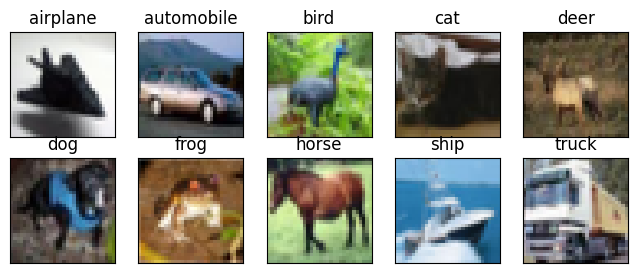

In [ ]:
class_names = ['airplane','automobile','bird','cat','deer','dog','frog','horse','ship','truck']
fig = plt.figure(figsize=(8,3))
num_classes = 10
for i in range(num_classes):
    ax = fig.add_subplot(2,5,1+i, xticks=[], yticks=[])
    ax.set_title(class_names[i])
    img = next(img for img, label in cifar10 if label ==i)
    plt.imshow(img)
plt.show()

In [ ]:
transforms_cifar10 = datasets.CIFAR10(data_path, train=True, download=False, transform=transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.4915, 0.4823, 0.4468), (0.2470, 0.2435, 0.2616))]))
transforms_cifar10_val = datasets.CIFAR10(data_path, train=False, download=False,transform=transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.4915, 0.4823, 0.4468),(0.2470, 0.2435, 0.2616))]))

In [ ]:
tensor_cifar10 = datasets.CIFAR10(data_path, train=True, download=False, transform=transforms.ToTensor())
#dir(transforms)

In [ ]:
imgs = torch.stack([img_t for img_t, _ in tensor_cifar10], dim=3)
imgs.shape

torch.Size([3, 32, 32, 50000])

In [ ]:
imgs.view(3, -1).mean(dim=1)

tensor([0.4914, 0.4822, 0.4465])

In [ ]:
imgs.view(3, -1).std(dim=1)

tensor([0.2470, 0.2435, 0.2616])

In [ ]:
transforms.Normalize((0.4915, 0.4823, 0.4468), (0.2470, 0.2435, 0.2616))

Normalize(mean=(0.4915, 0.4823, 0.4468), std=(0.247, 0.2435, 0.2616))

In [ ]:
transforms_cifar10 = datasets.CIFAR10(data_path, train=True, download=False, transform=transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.4915, 0.4823, 0.4468), (0.2470, 0.2435, 0.2616))]))
transforms_cifar10_val = datasets.CIFAR10(data_path, train=False, download=False,transform=transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.4915, 0.4823, 0.4468),(0.2470, 0.2435, 0.2616))]))

In [ ]:
train_loader = torch.utils.data.DataLoader(transforms_cifar10, batch_size=64,shuffle=True)
val_loader = torch.utils.data.DataLoader(transforms_cifar10_val, batch_size=64,shuffle=False)

learning_rate = 1e-1
n_epochs = 300

In [ ]:
class NetRes10(nn.Module):
    def __init__(self, n_chans1=32):
        super().__init__()
        self.n_chans1 = n_chans1
        self.conv1 = nn.Conv2d(3, n_chans1, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(n_chans1, n_chans1 // 2, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(n_chans1 // 2, n_chans1 // 2, kernel_size=3, padding=1)
        self.fc1 = nn.Linear(4 * 4 * n_chans1 // 2, 32)
        self.fc2 = nn.Linear(32, 10)

    def forward(self, x):
        out = F.max_pool2d(torch.relu(self.conv1(x)), 2)
        out = F.max_pool2d(torch.relu(self.conv2(out)), 2)
        out1 = out
        out = F.max_pool2d(torch.relu(self.conv3(out)) + out1, 2)
        out = out.view(-1, 4 * 4 * self.n_chans1 // 2)
        out = torch.relu(self.fc1(out))
        out = self.fc2(out)
        return out

In [ ]:
class NetDropout(nn.Module):
    def __init__(self, n_chans1=32):
        super().__init__()
        self.n_chans1 = n_chans1
        self.conv1 = nn.Conv2d(3, n_chans1, kernel_size=3, padding=1)
        self.conv1_dropout = nn.Dropout2d(p=0.3)
        self.conv2 = nn.Conv2d(n_chans1, n_chans1 // 2, kernel_size=3,
        padding=1)
        self.conv2_dropout = nn.Dropout2d(p=0.3)
        self.fc1 = nn.Linear(8 * 8 * n_chans1 // 2, 32)
        self.fc2 = nn.Linear(32, 10)

    def forward(self, x):
        out = F.max_pool2d(torch.tanh(self.conv1(x)), 2)
        out = self.conv1_dropout(out)
        out = F.max_pool2d(torch.tanh(self.conv2(out)), 2)
        out = self.conv2_dropout(out)
        out = out.view(-1, 8 * 8 * self.n_chans1 // 2)
        out = torch.tanh(self.fc1(out))
        out = self.fc2(out)
        return out

In [ ]:
class NetBatchNorm(nn.Module):
    def __init__(self, n_chans1=32):
        super().__init__()
        self.n_chans1 = n_chans1
        self.conv1 = nn.Conv2d(3, n_chans1, kernel_size=3, padding=1)
        self.conv1_batchnorm = nn.BatchNorm2d(num_features=n_chans1)
        self.conv2 = nn.Conv2d(n_chans1, n_chans1 // 2, kernel_size=3, padding=1)
        self.conv2_batchnorm = nn.BatchNorm2d(num_features=n_chans1 // 2)
        self.fc1 = nn.Linear(8 * 8 * n_chans1 // 2, 32)
        self.fc2 = nn.Linear(32, 10)

    def forward(self, x):
        out = self.conv1_batchnorm(self.conv1(x))
        out = F.max_pool2d(torch.tanh(out), 2)
        out = self.conv2_batchnorm(self.conv2(out))
        out = F.max_pool2d(torch.tanh(out), 2)
        out = out.view(-1, 8 * 8 * self.n_chans1 // 2)
        out = torch.tanh(self.fc1(out))
        out = self.fc2(out)
        return out

In [ ]:
def training_loop(n_epochs, optimizer, model, loss_fn, train_loader):
    main_tic = time.perf_counter()
    for epoch in range(1, n_epochs + 1):
        loss_train = 0
        tic = time.perf_counter()
        for imgs, labels in train_loader:
            imgs = imgs.to(device = device)
            labels = labels.to(device = device)
            outputs = model(imgs)
            loss = loss_fn(outputs, labels)
            l2_lambda = 0.001
            l2_norm = sum(p.pow(2.0).sum()
                          for p in model.parameters())
            loss = loss + l2_lambda * l2_norm
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            loss_train += loss.item()

        toc = time.perf_counter()

        #if epoch == 0 or epoch % 10 ==1:
          print(f"Epoch {epoch}, Duration = {round(toc - tic, 3)} seconds, Loss: {round(loss_train / len(train_loader), 5)}")

    main_toc = time.perf_counter()
    print(f"Total Training Time = {round(main_toc - main_tic, 3)} seconds")
    print(f"Average Training Time per Epoch = {round((main_toc - main_tic) / n_epochs , 3)} seconds")

In [ ]:
def validate(model, train_loader, val_loader):
    for name, loader in [("Training", train_loader), ("Validation", val_loader)]:
        correct = 0
        total = 0
        val_tic = time.perf_counter()
        with torch.no_grad():
            for imgs, labels in loader:
                imgs = imgs.to(device = device)
                labels = labels.to(device = device)
                outputs = model(imgs)
                _, predicted = torch.max(outputs, dim=1)
                total += labels.shape[0]
                correct += int((predicted == labels).sum())
        val_toc = time.perf_counter()

        print(f"Loader: {name}, Accuracy: {round(correct/total, 3)}, Duration = {round(val_toc - val_tic, 3)} seconds")

In [ ]:
#Using Adam optimizer

model = NetRes10()
if torch.cuda.is_available():
    model.cuda()
optimizer = optim.Adam(model.parameters(), lr = learning_rate)
loss_fn = nn.CrossEntropyLoss()
training_loop(n_epochs, optimizer, model, loss_fn, train_loader)

Epoch 1, Duration = 21.936 seconds, Loss: 5.42265
Epoch 2, Duration = 15.542 seconds, Loss: 6.20396
Epoch 3, Duration = 15.565 seconds, Loss: 5.23473
Epoch 4, Duration = 15.884 seconds, Loss: 4.10011
Epoch 5, Duration = 15.476 seconds, Loss: 3.28811
Epoch 6, Duration = 15.243 seconds, Loss: 2.7937
Epoch 7, Duration = 15.085 seconds, Loss: 2.51997
Epoch 8, Duration = 15.16 seconds, Loss: 2.40983
Epoch 9, Duration = 15.62 seconds, Loss: 12.64305
Epoch 10, Duration = 15.745 seconds, Loss: 9.68922
Epoch 11, Duration = 15.633 seconds, Loss: 6.78435
Epoch 12, Duration = 15.357 seconds, Loss: 5.18473
Epoch 13, Duration = 15.492 seconds, Loss: 4.01243
Epoch 14, Duration = 15.253 seconds, Loss: 3.75755
Epoch 15, Duration = 15.374 seconds, Loss: 5.36222
Epoch 16, Duration = 15.408 seconds, Loss: 6.39129
Epoch 17, Duration = 15.787 seconds, Loss: 14.16136
Epoch 18, Duration = 15.285 seconds, Loss: 30.54335
Epoch 19, Duration = 15.129 seconds, Loss: 30.9836
Epoch 20, Duration = 15.133 seconds, Los

In [ ]:
validate(model, train_loader, val_loader)

Loader: Training, Accuracy: 0.1, Duration = 13.798 seconds
Loader: Validation, Accuracy: 0.1, Duration = 2.664 seconds


In [ ]:
model = NetDropout()
if torch.cuda.is_available():
    model.cuda()
optimizer = optim.Adam(model.parameters(), lr = learning_rate)
loss_fn = nn.CrossEntropyLoss()
training_loop(n_epochs, optimizer, model, loss_fn, train_loader)

Epoch 1, Duration = 16.55 seconds, Loss: 5.38919
Epoch 2, Duration = 15.713 seconds, Loss: 5.58066
Epoch 3, Duration = 15.498 seconds, Loss: 5.58763
Epoch 4, Duration = 15.493 seconds, Loss: 5.39793
Epoch 5, Duration = 15.667 seconds, Loss: 5.41093
Epoch 6, Duration = 15.431 seconds, Loss: 5.42994
Epoch 7, Duration = 16.262 seconds, Loss: 5.59783
Epoch 8, Duration = 16.116 seconds, Loss: 5.50695
Epoch 9, Duration = 15.407 seconds, Loss: 5.4455
Epoch 10, Duration = 15.579 seconds, Loss: 5.58589
Epoch 11, Duration = 15.516 seconds, Loss: 5.36595
Epoch 12, Duration = 15.391 seconds, Loss: 5.41399
Epoch 13, Duration = 15.484 seconds, Loss: 5.56169
Epoch 14, Duration = 15.879 seconds, Loss: 5.6306
Epoch 15, Duration = 16.167 seconds, Loss: 5.5285
Epoch 16, Duration = 15.426 seconds, Loss: 5.56868
Epoch 17, Duration = 15.301 seconds, Loss: 5.50933
Epoch 18, Duration = 15.806 seconds, Loss: 5.54888
Epoch 19, Duration = 15.458 seconds, Loss: 5.51661
Epoch 20, Duration = 15.458 seconds, Loss: 5

In [ ]:
validate(model, train_loader, val_loader)

Loader: Training, Accuracy: 0.173, Duration = 13.068 seconds
Loader: Validation, Accuracy: 0.171, Duration = 2.411 seconds


In [ ]:
model = NetBatchNorm()
if torch.cuda.is_available():
    model.cuda()
optimizer = optim.Adam(model.parameters(), lr = learning_rate)
loss_fn = nn.CrossEntropyLoss()
training_loop(n_epochs, optimizer, model, loss_fn, train_loader)

Epoch 1, Duration = 15.603 seconds, Loss: 4.09767
Epoch 2, Duration = 15.564 seconds, Loss: 4.17097
Epoch 3, Duration = 15.46 seconds, Loss: 4.61366
Epoch 4, Duration = 16.695 seconds, Loss: 5.02267
Epoch 5, Duration = 15.953 seconds, Loss: 3.81011
Epoch 6, Duration = 15.639 seconds, Loss: 5.51771
Epoch 7, Duration = 15.347 seconds, Loss: 4.01663
Epoch 8, Duration = 15.421 seconds, Loss: 4.1179
Epoch 9, Duration = 15.325 seconds, Loss: 4.49023
Epoch 10, Duration = 15.698 seconds, Loss: 4.38631
Epoch 11, Duration = 16.089 seconds, Loss: 4.31253
Epoch 12, Duration = 15.591 seconds, Loss: 4.64406
Epoch 13, Duration = 15.211 seconds, Loss: 4.1385
Epoch 14, Duration = 15.479 seconds, Loss: 4.43351
Epoch 15, Duration = 15.495 seconds, Loss: 4.11337
Epoch 16, Duration = 15.666 seconds, Loss: 4.31568
Epoch 17, Duration = 15.698 seconds, Loss: 4.33747
Epoch 18, Duration = 16.383 seconds, Loss: 4.52646
Epoch 19, Duration = 15.64 seconds, Loss: 4.55753
Epoch 20, Duration = 15.668 seconds, Loss: 4

In [ ]:
validate(model, train_loader, val_loader)

Loader: Training, Accuracy: 0.175, Duration = 12.818 seconds
Loader: Validation, Accuracy: 0.176, Duration = 2.77 seconds
